In [251]:
##### Main libraries/modules
# import json, os, subprocess, shapely
import os, json
# import rasterio as rio
# from rasterio.plot import show
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
# import pandas as pd
from shapely import geometry
saveDir = os.getcwd()+'\\output\\TeamMeeting_031620\\'


In [187]:
##### Function to calculate the epicentral and hypocentral distances using the haversine equation

def get_haversine_dist(r,lat1,long1,lat2,long2,z=0):
    r = 6371 # km
#     r = 3963.19 # miles
    # Haversine
    d = 2*r*np.arcsin(np.sqrt(np.sin((lat2-lat1)/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin((long2-long1)/2)**2))
    return d, np.sqrt(d**2 + z**2)

In [222]:
##### Import liquefaction susceptibility map for Bay Area
##### https://pubs.usgs.gov/of/2006/1037/
# df_susc = gpd.GeoDataFrame.from_file('C:\\Users\\BarryZheng\\Downloads\\of06-1037_4b.shp\\'+'sfq2py.shp')
df_liq_susc = gpd.GeoDataFrame.from_file(os.getcwd()+'\\of06-1037_4b.shp\\sfq2py.shp')
liq_susc_dict = {'VL': 'very low',
                 'L': 'low',
                 'M': 'low',
                 'H': 'low',
                 'L': 'low',
                 'W': 'water',
                 'NM': 'not mapped'}
cmap_liq_susc_dict = {'VH': np.minimum(np.divide([238,28,37],255),1),
                      'H': np.minimum(np.divide([253,178,21],255),1),
                      'M': np.minimum(np.divide([255,241,0],255),1),
                      'L': np.minimum(np.divide([162,204,57],255),1),
                      'VL': np.minimum(np.divide([243,243,244],255),1),
                      'W': np.minimum(np.divide([235,247,253],255),1),
                      'NM': 'None'}
cmap_arr = [cmap_liq_susc_dict.get(i,None) for i in df_liq_susc['LIQ'].values]
df_liq_susc['color'] = cmap_arr

In [218]:
###### make grid
xbounds = ([-122.8,-121.5]) # bay area
ybounds = ([37,38.5]) # bay area
dcoord = 0.001
# xbounds = ([-122.45,-122.25]) # zoomed in to alameda
# ybounds = ([37.77,38.025]) # zoomed in to alameda
# dcoord = 0.0005
# xbounds = ([-122.5,-121.9])
# ybounds = ([37.4,38.1])
# grid_x_tick = np.linspace(xbounds[0],xbounds[1],int((xbounds[1]-xbounds[0])/dcoord+2))
# grid_y_tick = np.linspace(ybounds[0],ybounds[1],int((ybounds[1]-ybounds[0])/dcoord+2))
grid_x_tick = np.arange(xbounds[0],xbounds[1]+dcoord,dcoord)
grid_y_tick = np.arange(ybounds[0],ybounds[1]+dcoord,dcoord)
grid_x_mid = [(grid_x_tick[i] + grid_x_tick[i+1])/2 for i in range(len(grid_x_tick)-1)]
grid_y_mid = [(grid_y_tick[i] + grid_y_tick[i+1])/2 for i in range(len(grid_y_tick)-1)]
xarr, yarr = np.meshgrid(grid_x_mid,grid_y_mid)
mat_shape = xarr.shape
xarr_rs = np.reshape(xarr.T,mat_shape[0]*mat_shape[1],1)
yarr_rs = np.reshape(yarr.T,mat_shape[0]*mat_shape[1],1)
listcoords = np.transpose(np.vstack([xarr_rs,yarr_rs]))
rows = range(mat_shape[0])
cols = range(mat_shape[1])

In [207]:
rows,cols

(range(0, 301), range(0, 260))

In [143]:
# with open(os.getcwd()+'\\UCERF3Ruptures100.geojeson', 'r') as f:
#     jd = json.load(f)
# rates = []
# rup_coord = []
# mag = []
# rup_ind = []
# source_in = []
# dtot = []
# for i in jd['features']:
#     rates.append(i['properties']['MeanAnnualRate'])
#     mag.append(i['properties']['Magnitude'])
#     rup_ind.append(i['properties']['Rupture'])
#     source_in.append(i['properties']['Source'])
#     dtot.append(i['properties']['Distance'])
#     rup_coord.append(i['geometry']['coordinates'])
# # rates = np.asarray(rates)
# # mag = np.asarray(mag)
# # rup_ind = np.asarray(rup_ind)
# # source_in = np.asarray(source_in)
# # dtot = np.asarray(dtot)
# # rup_coord = np.asarray(rup_coord)
# rup_coord_rad = np.asarray([np.radians(i) for i in rup_coord])

In [219]:
## hayward fault
rup_coord = np.loadtxt(os.getcwd()+'\\hayward_no.txt')
rup_coord_rad = np.radians(rup_coord)
dl_rup = 0.1 # miles
##
d_rup = []
dd_rup = []
nl_rup = []
rup_coord_start = []
rup_coord_end = []
rup_coord_mid = []
for i in range(len(rup_coord_rad)-1):
#     for i in range(1):
    temp,_ = get_haversine_dist(0,rup_coord_rad[i][1],rup_coord_rad[i][0],
                                rup_coord_rad[i+1][1],rup_coord_rad[i+1][0])
    d_rup.append(temp)
    temp2 = np.int(np.ceil(temp/dl_rup))
    nl_rup.append(temp2)
    if temp2 > 0:
        d_long = (rup_coord[i+1][0] - rup_coord[i][0])/temp2
        d_lat = (rup_coord[i+1][1] - rup_coord[i][1])/temp2
        for j in range(temp2):
            dd_rup.append(temp/temp2)
            rup_coord_start.append([rup_coord[i][0]+d_long*j,rup_coord[i][1]+d_lat*j])
            rup_coord_end.append([rup_coord[i][0]+d_long*(j+1),rup_coord[i][1]+d_lat*(j+1)])
            rup_coord_mid.append([rup_coord[i][0]+d_long*(j+0.5),rup_coord[i][1]+d_lat*(j+0.5)])

p_rup_scen_mid = dd_rup/sum(d_rup)
d_rup = np.asarray(d_rup)
dd_rup = np.asarray(dd_rup)
nl_rup = np.asarray(nl_rup)
rup_coord_start = np.asarray(rup_coord_start)
rup_coord_end = np.asarray(rup_coord_end)
rup_coord_mid = np.asarray(rup_coord_mid)

In [127]:
## Import rupture scenarios and rates
# rup_scen = np.loadtxt('rup_0_606.txt')
# rup_scen_rad = np.radians(rup_scen)
# rup_scen_rad = np.asarray([np.radians(i) for i in rup_coord])
# filePath_rates = [os.getcwd()+'//output//sim_s5_fn_ucerf3_0_606_out.json']
# rates = []
# for i in filePath_rates:
#     with open(i, 'r') as f:
#         jd = json.load(f)
#     rates.append(jd['EqRupture']['MeanAnnualRate'])
# rates

In [9]:
# df_fault = gpd.GeoDataFrame.from_file('C:\\Users\\Barry\\Desktop\\Qfaults_GIS\\GIS Files\\Shapefile\\QFaults.shp')

In [159]:
# m-r criteria
m_cutoff_YB78 = 7.6
m_crit = np.linspace(5,9,(9-5)/0.1+1)
r_crit_YP78 = [10**(np.log10(150/1)/(m_cutoff_YB78-5)*(min(i,m_cutoff_YB78)-5)+np.log10(1)) for i in m_crit]
# r_crit_YP78 = [10**(np.log10(150/1)/(m_cutoff_YB78-5)*(i-5)+np.log10(1)) for i in m_crit]
r_crit_KT75 = [10**(np.log10(100/10)/(7.46-6.29)*(i-6.29)+np.log10(10)) for i in m_crit]
r_crit = r_crit_YP78

C:\Users\Barry\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


In [220]:
### recurrence for hayward no fault
m_tick = [5,5.5,6,6.5,7,7.5,8]
# m_tick = [6.4,6.6,6.8,7.0,7.2,7.4,7.6]
m_bin = [(m_tick[i] + m_tick[i+1])/2 for i in range(len(m_tick)-1)]
r_bin_crit = [np.interp(i,m_crit,r_crit) for i in m_bin]
f_bin_fault = np.divide([6e-2,2.3e-2,1.3e-2,8e-3,3e-4,0],len(rup_coord_mid))
# f_bin_areal = np.divide([16,8,4,2],1000)/len(xy_pair_areal)

In [221]:
zero_mat = np.zeros(xarr.shape)
rate_mat = zero_mat
##
for k in rup_coord_mid:
    r = 2*6371*np.arcsin(np.sqrt(np.sin((np.radians(k[1])-np.radians(yarr))/2)**2 +\
                                 np.cos(np.radians(yarr))*np.cos(np.radians(k[1]))*\
                                 np.sin((np.radians(k[0])-np.radians(xarr))/2)**2))
#     r = np.sqrt((k[0]-xarr)**2 + (k[1]-yarr)**2)
    for l in range(len(m_bin)):
        check = r_bin_crit[l] > r
        rate_mat = rate_mat + check*f_bin_fault[l]
#         print('fault[' + str(k) + ']: m_bin = ' + str(m_bin[l]) + ': ' + str(rate_mat[130,20]))

In [224]:
Tf_mat = np.zeros(xarr.shape)
check1 = rate_mat > 0
check2 = rate_mat <= 0
Tf_mat[check1] = 1/rate_mat[check1]
Tf_mat[check2] = np.inf

[1.6264946157632805,
 4.263160842720737,
 11.174055047442282,
 29.288012066555147,
 76.76601262198238,
 150.00000000000003]

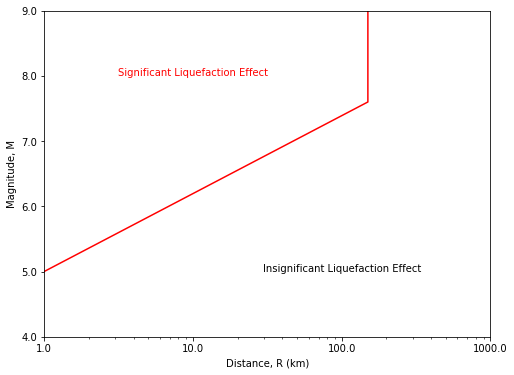

In [90]:
nx = 1
ny = 1
fontsize_label = 16
fontsize_axis = 12
fontname = 'arial'
##
figsize = (8,6)
fig, ax = plt.subplots(nx, ny, figsize=figsize)
##
ax.semilogx(r_crit,m_crit,'r')
# ax.semilogx(r_bin_crit,m_bin,'or')
# [ax.semilogx([1,r_bin_crit[i]],[m_bin[i],m_bin[i]],'--r') for i in range(len(m_bin))]
ax.text(10,8,'Significant Liquefaction Effect',color='r',horizontalalignment='center')
ax.text(100,5,'Insignificant Liquefaction Effect',color='k',horizontalalignment='center')
##
ax.set_xlim([1,1000])
ax.set_ylim([4,9])
ax.set_xticklabels(ax.get_xticks())
ax.set_yticklabels(ax.get_yticks())
ax.set_xlabel('Distance, R (km)')
ax.set_ylabel('Magnitude, M')
##
plt.show()

In [147]:
Tf_mat = zero_mat
check1 = rate_mat > 0
check2 = rate_mat <= 0
Tf_mat[check1] = 1/rate_mat[check1]
Tf_mat[check2] = np.inf

In [238]:
##
# filters = Tf_mat == -999
# prob_liq[filters] = np.nan
levels_Tf=[50,75,100,200,400,np.inf]
levels_Tf_norm = np.linspace(0,1,len(levels_Tf))
# prob_liq_norm = 
Tf_mat_norm = np.interp(Tf_mat,levels_Tf,levels_Tf_norm)
# filters = np.isnan(prob_liq_norm)
# prob_liq_norm[filters] = -999

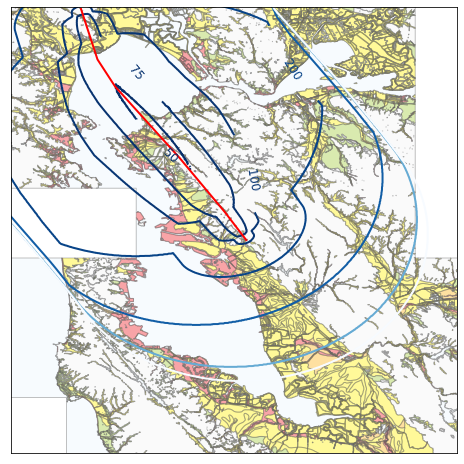

In [262]:
nx = 1
ny = 1
fontsize_label = 16
fontsize_axis = 12
fontname = 'arial'
##
figsize = (8,9.5)
fig, ax = plt.subplots(nx, ny, figsize=figsize)
##
# [ax.plot([i,i],[0,grid_y],'-',color=[0.7,0.7,0.7],alpha=0.5) for i in grid_x_tick]
# [ax.plot([0,grid_x],[j,j],'-',color=[0.7,0.7,0.7],alpha=0.5) for j in grid_y_tick]
# ax.plot(xy_pair_areal[:,[0]],xy_pair_areal[:,[1]],'or')
df_liq_susc.plot(ax=ax, color=df_liq_susc['color'], ec=[0.4,0.4,0.4], alpha=0.4, legend=True)
# [ax.plot(np.transpose(i)[0],np.transpose(i)[1],'-r') for i in rup_coord]
ax.plot(rup_coord[:,[0]],rup_coord[:,[1]],'-r',lw=2)
levels = [50, 75, 100, 200, 400, 1000, 2000]
# levels = [200, 250, 300, 400, 500, 750, 1000, 2000, 4000]
# ax.contour(xarr,yarr,rate_mat)
cs = ax.contour(xarr,yarr,Tf_mat,levels,cmap='Blues_r',linewidths=2)
plt.clabel(cs,levels,fmt='%5.0f',fontsize=12)
# ax.pcolormesh(xarr,yarr,Tf_mat_norm,cmap='Blues_r',alpha=0.8)
# plt.plot(xy_pair[:,[0]],xy_pair[:,[1]],'ok',markersize=4)
# cs2 = ax.contourf(xarr,yarr,Tf_mat,[0,500,2000],cmap='Blues_r')
##
# ax.set_xlim([-122.45,-122.25]) # zoomed into alameda
# ax.set_ylim([37.77,38.025]) # zoomed into alameda
# ax.set_xlim([-122.8,-121.55]) # bay area
# ax.set_ylim([37.1,38.3]) # bay area
ax.set_xlim([-122.6,-121.8]) # bay area, closer
ax.set_ylim([37.4,38.2]) # bay area, closer
# ax.set_xlabel('X (mi)')
# ax.set_ylabel('Y (km)')
# ax.set_facecolor((0.1,0.1,0.1))
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
plt.savefig(saveDir+'youd_perkins_bay_area_hayward.png',dpi=100,format='png',quality=100,bbox_inches='tight')
##
plt.show()

In [237]:
np.max(Tf_mat)

inf

In [9]:
np.min(Tf_mat)

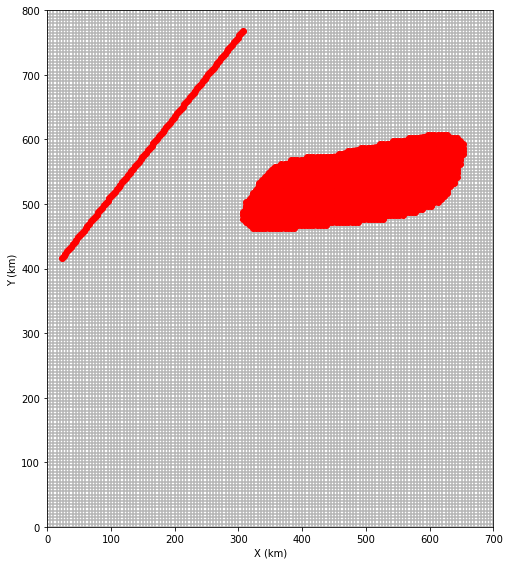

In [9]:
nx = 1
ny = 1
fontsize_label = 16
fontsize_axis = 12
fontname = 'arial'
##
figsize = (8,9.5)
fig, ax = plt.subplots(nx, ny, figsize=figsize)
##
# for i in grid_x_mid:
#     for j in grid_y_mid:
#         plt.plot(i,j,'ok')
[ax.plot([i,i],[0,grid_y],'-',color=[0.7,0.7,0.7]) for i in grid_x_tick]
[ax.plot([0,grid_x],[j,j],'-',color=[0.7,0.7,0.7]) for j in grid_y_tick]
ax.plot(*areal_source_poly.exterior.xy,'r')
ax.plot(xy_pair_areal[:,[0]],xy_pair_areal[:,[1]],'or')
ax.plot(fault_source[:,[0]],fault_source[:,[1]],'-r')
ax.plot(fault_list[:,[0]],fault_list[:,[1]],'or')
# plt.plot(xy_pair[:,[0]],xy_pair[:,[1]],'ok',markersize=4)
##
ax.set_xlim([0,grid_x])
ax.set_ylim([0,grid_y])
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
##
plt.show()

In [10]:
zero_mat = np.zeros(xarr.shape)
rate_mat = zero_mat
##
for k in fault_list:
#     r = 2*6371*np.arcsin(np.sqrt(np.sin((np.radians(k[1])-np.radians(yarr))/2)**2 +\
#                                  np.cos(np.radians(yarr))*np.cos(np.radians(k[1]))*\
#                                  np.sin((np.radians(k[0])-np.radians(xarr))/2)**2))
    r = np.sqrt((k[0]-xarr)**2 + (k[1]-yarr)**2)
    for l in range(len(m_bin)):
        check = r_bin_crit[l] > r
        rate_mat = rate_mat + check*f_bin_fault[l]
#         print('fault[' + str(k) + ']: m_bin = ' + str(m_bin[l]) + ': ' + str(rate_mat[130,20]))
##
for k in xy_pair_areal:
#     r = 2*6371*np.arcsin(np.sqrt(np.sin((np.radians(k[1])-np.radians(yarr))/2)**2 +\
#                                  np.cos(np.radians(yarr))*np.cos(np.radians(k[1]))*\
#                                  np.sin((np.radians(k[0])-np.radians(xarr))/2)**2))
    r = np.sqrt((k[0]-xarr)**2 + (k[1]-yarr)**2)
    for l in range(len(m_bin)):
        check = r_bin_crit[l] > r
        rate_mat = rate_mat + check*f_bin_areal[l]
#         print('fault[' + str(k) + ']: m_bin = ' + str(m_bin[l]) + ': ' + str(rate_mat[100,100]))

In [11]:
Tf_mat = np.zeros(xarr.shape)
check1 = rate_mat > 0
check2 = rate_mat <= 0
Tf_mat[check1] = 1/rate_mat[check1]
Tf_mat[check2] = np.inf

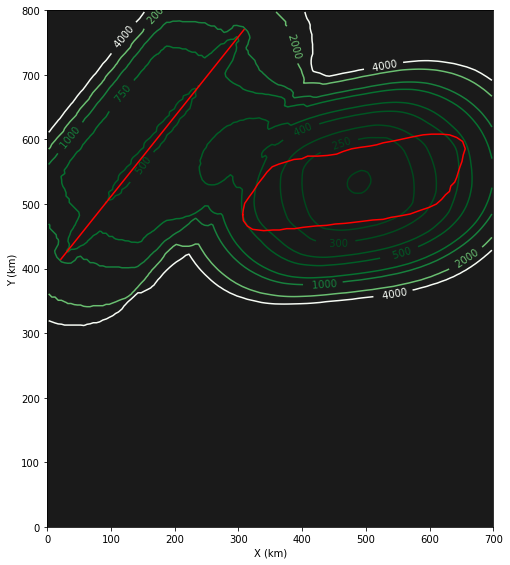

In [12]:
nx = 1
ny = 1
fontsize_label = 16
fontsize_axis = 12
fontname = 'arial'
##
figsize = (8,9.5)
fig, ax = plt.subplots(nx, ny, figsize=figsize)
##
# [ax.plot([i,i],[0,grid_y],'-',color=[0.7,0.7,0.7],alpha=0.5) for i in grid_x_tick]
# [ax.plot([0,grid_x],[j,j],'-',color=[0.7,0.7,0.7],alpha=0.5) for j in grid_y_tick]
ax.plot(*areal_source_poly.exterior.xy,'r')
# ax.plot(xy_pair_areal[:,[0]],xy_pair_areal[:,[1]],'or')
ax.plot(fault_source[:,[0]],fault_source[:,[1]],'-r')
# ax.plot(fault_list[:,[0]],fault_list[:,[1]],'or')
levels = [200, 250, 300, 400, 500, 750, 1000, 2000, 4000]
# ax.contour(xarr,yarr,rate_mat)
cs = ax.contour(xarr,yarr,Tf_mat,levels,cmap='Greens_r')
plt.clabel(cs,levels,fmt='%5.0f')
# plt.plot(xy_pair[:,[0]],xy_pair[:,[1]],'ok',markersize=4)
# cs2 = ax.contourf(xarr,yarr,Tf_mat,[0,500,2000],cmap='Blues_r')
##
ax.set_xlim([0,grid_x])
ax.set_ylim([0,grid_y])
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_facecolor((0.1,0.1,0.1))
##
plt.show()